### **Index Tracking Portfolio Stock Selection**

### Set-up

In [ ]:
!pip install yfinance 
!pip install pandas
!pip install openpyxl 
!pip install numpy 
!pip install scipy 
!pip install matplotlib
!pip install tabulate
!pip install seaborn
!pip install PyPortfolioOpt

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML
from datetime import datetime
#import seaborn as sns
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import plotting

### Preliminary Analysis - Composition by Sector & Industry

In [3]:
# Tickers as of 29/10/24
ftse100_tickers_df = pd.read_excel("ftse_stock_tickers.xlsx", sheet_name="ftse100_constituents")
ftse350_tickers_df = pd.read_excel("ftse_stock_tickers.xlsx", sheet_name="ftse350_constituents")

#### Get FTSE100 Company Profiles

In [4]:
def get_company_info(ticker):
    try:
        # Append '.L' to indicate LSE listing on Yahoo Finance
        if ticker.endswith('.'):
            lse_ticker = f"{ticker}L"
        elif ticker.endswith('.A'):
            lse_ticker = ticker.replace('.A', '-A.L')
        else:
            lse_ticker = f"{ticker}.L" 

        yf_ticker = yf.Ticker(lse_ticker)
        company_info = yf_ticker.info
    
        return {
            'ticker': lse_ticker,
            'name': company_info.get('longName', 'N/A'),
            'sector': company_info.get('sector', 'N/A'),
            'industry': company_info.get('industry', 'N/A'),
            'market_cap': company_info.get('marketCap', 'N/A'),
        }
    
    except Exception as e:
        print(f"Could not retrieve info for {ticker}: {e}")
        return None

In [5]:
ftse100_tickers = ftse100_tickers_df['ticker']

company_data = [get_company_info(ticker) for ticker in ftse100_tickers]
# company_data = [data for data in company_data if data] 

ftse100_company_info = pd.DataFrame(company_data)

print(ftse100_company_info)

    ticker                      name                  sector  \
0   HSBA.L         HSBC Holdings plc      Financial Services   
1   PSON.L               Pearson plc  Communication Services   
2   ANTO.L           Antofagasta plc         Basic Materials   
3    PRU.L            Prudential plc      Financial Services   
4   STAN.L    Standard Chartered PLC      Financial Services   
..     ...                       ...                     ...   
95    RR.L  Rolls-Royce Holdings plc             Industrials   
96    BP.L                 BP p.l.c.                  Energy   
97    JD.L     JD Sports Fashion Plc       Consumer Cyclical   
98   MRO.L    Melrose Industries PLC             Industrials   
99   AAF.L         Airtel Africa Plc  Communication Services   

                          industry    market_cap  
0              Banks - Diversified  129307500544  
1                       Publishing    7975813120  
2                           Copper   17291931648  
3                 Insurance

#### Clean N/A Company Profiles

This section is specific to the composition of the FTSE100 on 29/10/2024. The results for its composition are saved in the excel submission file.

In [6]:
# save to clean missing information 
ftse100_company_info.to_csv('company_data.csv', index=False)

temp_df = ftse100_company_info[ftse100_company_info['sector'] == 'N/A']
print(temp_df)

    ticker                          name sector industry   market_cap
57  FCIT.L      F&C Investment Trust Ord    N/A      N/A   5312845824
59   III.L                  3i Group Ord    N/A      N/A  32692785152
70   PSH.L  Pershing Square Holdings Ord    N/A      N/A   6673970176
71   SMT.L         Scottish Mortgage Ord    N/A      N/A  11507076096


In [7]:
tickers_to_update = ['FCIT.L', 'PSH.L', 'SMT.L', 'III.L', 'PSH.L']

# Replace the sector for these tickers with 'Financial Services'
ftse100_company_info.loc[ftse100_company_info['ticker'].isin(tickers_to_update), 'sector'] = 'Financial Services'

#### Calculate Composition by Market Cap - IGNORE

This section was not deemed useful in selecting the stock portfolio or its weights, and thus can be ignored. 

In [8]:
total_market_cap = ftse100_company_info['market_cap'].sum()

sector_market_cap = ftse100_company_info.groupby('sector')['market_cap'].sum().reset_index()
sector_market_cap['sector_market_cap_proportion'] = sector_market_cap['market_cap'] / total_market_cap

print("Sector Market Cap Proportion:")
print(sector_market_cap)

Sector Market Cap Proportion:
                    sector    market_cap  sector_market_cap_proportion
0          Basic Materials  195232296960                      0.091783
1   Communication Services   76864082176                      0.036135
2        Consumer Cyclical  138865881856                      0.065284
3       Consumer Defensive  352136372736                      0.165547
4                   Energy  224695299584                      0.105634
5       Financial Services  452920163072                      0.212927
6               Healthcare  263193490688                      0.123733
7              Industrials  297971435264                      0.140083
8              Real Estate   26891190528                      0.012642
9               Technology   10372221952                      0.004876
10               Utilities   87968928256                      0.041356


#### Get FTSE350 Company Profiles

In [9]:
tickers = ftse350_tickers_df['ticker']

company_data = [get_company_info(ticker) for ticker in tickers]
# company_data = [data for data in company_data if data] 

ftse350_df = pd.DataFrame(company_data)

In [10]:
# Remove stocks without company profiles
ftse350_df = ftse350_df.replace('N/A', pd.NA).dropna()
print(ftse350_df)

     ticker                                  name                  sector  \
0    HSBA.L                     HSBC Holdings plc      Financial Services   
1    PSON.L                           Pearson plc  Communication Services   
2    ANTO.L                       Antofagasta plc         Basic Materials   
3     ELM.L                         Elementis plc         Basic Materials   
4    STAN.L                Standard Chartered PLC      Financial Services   
..      ...                                   ...                     ...   
338   AAF.L                     Airtel Africa Plc  Communication Services   
339  PLUS.L                          Plus500 Ltd.      Financial Services   
340   CWR.L              Ceres Power Holdings plc             Industrials   
341  CMCX.L                       CMC Markets Plc      Financial Services   
349  ALFA.L  Alfa Financial Software Holdings PLC              Technology   

                         industry    market_cap  
0             Banks - Div

#### Categorise Companies by Sector & Market Cap Level

In [11]:
# Define the market cap categories
def market_cap_category(market_cap):
    if market_cap >= 10e9:
        return 'Large-cap'
    elif 2e9 <= market_cap < 10e9:
        return 'Mid-cap'
    elif 300e6 <= market_cap < 2e9:
        return 'Small-cap'
    else:
        return None  

ftse350_df['category'] = ftse350_df['market_cap'].apply(market_cap_category)

grouped_df = ftse350_df.groupby(['category', 'sector'])

for (category, sector), group in grouped_df:
    print(f"Category: {category}, Sector: {sector}")
    print(group[['ticker', 'name', 'market_cap']])
    print("\n")

Category: Large-cap, Sector: Basic Materials
    ticker                name   market_cap
2   ANTO.L     Antofagasta plc  17291931648
10  GLEN.L        Glencore plc  49503715328
15   AAL.L  Anglo American plc  29253521408
20   RIO.L     Rio Tinto Group  79368298496


Category: Large-cap, Sector: Communication Services
     ticker                                   name   market_cap
95    INF.L                            Informa plc  11009032192
274  BT-A.L                           BT Group plc  13990531072
292   VOD.L  Vodafone Group Public Limited Company  18756249600


Category: Large-cap, Sector: Consumer Cyclical
    ticker                               name   market_cap
73   IHG.L  InterContinental Hotels Group PLC  14447976448
119  NXT.L                           NEXT plc  11830177792
131  CPG.L                  Compass Group PLC  44738723840
251  CCL.L         Carnival Corporation & plc  21165559808


Category: Large-cap, Sector: Consumer Defensive
     ticker                    

#### Selected Stocks (Tickers)

In [12]:
selected_tickers = pd.read_excel("ftse_stock_tickers.xlsx", sheet_name="Selected Tickers")
# print(selected_tickers)

selected_tickers = selected_tickers['ticker'].tolist()
print(selected_tickers)

['RIO.L', 'VOD.L', 'CCL.L', 'TSCO.L', 'SHEL.L', 'HSBA.L', 'AZN.L', 'RR.L', 'SGRO.L', 'SGE.L', 'NG.L', 'EDV.L', 'PSON.L', 'JD.L', 'CCH.L', 'HBR.L', 'DLG.L', 'SN.L', 'DPLM.L', 'UTG.L', 'SCT.L', 'TRIG.L', 'IBST.L', 'HTWS.L', 'DOM.L', 'ITH.L', 'CMCX.L', 'PRTC.L', 'OXIG.L', 'TEP.L']


In [13]:
def get_selected_company_info(ticker):
    try:
        yf_ticker = yf.Ticker(ticker)
        company_info = yf_ticker.info
    
        return {
            'ticker': ticker,
            'name': company_info.get('longName', 'N/A'),
            'sector': company_info.get('sector', 'N/A'),
            'industry': company_info.get('industry', 'N/A'),
            'market_cap': company_info.get('marketCap', 'N/A'),
        }
    except Exception as e:
        print(f"Could not retrieve info for {ticker}: {e}")
        return None

In [14]:
selected_stocks_data = [get_selected_company_info(ticker) for ticker in selected_tickers]

selected_stocks_df = pd.DataFrame(selected_stocks_data)
print(selected_stocks_df)

    ticker                                   name                  sector  \
0    RIO.L                        Rio Tinto Group         Basic Materials   
1    VOD.L  Vodafone Group Public Limited Company  Communication Services   
2    CCL.L             Carnival Corporation & plc       Consumer Cyclical   
3   TSCO.L                              Tesco PLC      Consumer Defensive   
4   SHEL.L                              Shell plc                  Energy   
5   HSBA.L                      HSBC Holdings plc      Financial Services   
6    AZN.L                        AstraZeneca PLC              Healthcare   
7     RR.L               Rolls-Royce Holdings plc             Industrials   
8   SGRO.L                              SEGRO Plc             Real Estate   
9    SGE.L                     The Sage Group plc              Technology   
10    NG.L                      National Grid plc               Utilities   
11   EDV.L                   Endeavour Mining plc         Basic Materials   

In [15]:
# num_industries = selected_stocks_df['industry'].nunique()
# print(num_industries)

### **Index Tracking Portfolio Weight Calculation**

#### Amount of Data Required

**Objective:** Find the number of days of data $n$ required such that the standard deviation of mean daily returns is within $25\%$ of the expected mean daily returns.

##### 1. Calculate Daily Returns

The daily returns $R_t$ are calculated as the percentage change in the adjusted closing price $P_t$ for each day:

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

##### 2. Estimate the Mean and Deviation of Daily Returns

Then, the mean and standard deviation of daily returns as estimated as:

$$
\mu = \frac{1}{N} \sum_{t=1}^N R_t
$$

And,  

$$
\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^N (R_t - \mu)^2}
$$

##### 3. Calculating Sample Size $n$

$$

\frac{\sigma}{\sqrt{n}} = 0.25 \cdot \mu \Rightarrow n = \left( \frac{\sigma}{0.25 \cdot \mu} \right)^2

$$


In [16]:
ftse100_data = yf.download("^FTSE", start="2004-09-15", end="2024-09-15")

ftse100_data['Daily_Returns'] = ftse100_data['Adj Close'].pct_change()
mean_daily_return = ftse100_data['Daily_Returns'].mean()
std_daily_return = ftse100_data['Daily_Returns'].std()

n = (std_daily_return / (0.25 * mean_daily_return)) ** 2

print(n)
print(n/252)

[*********************100%***********************]  1 of 1 completed

60638.85139093957
240.63036266245862


Download and Format Data

In [17]:
selected_stock_data = yf.download(selected_tickers, start='2021-01-01', end='2024-09-15')['Adj Close']
ftse100_data = yf.download('^FTSE', start='2021-01-01', end='2024-09-15')['Adj Close']

# print(selected_stock_data)
# print(ftse100_data)

selected_stock_returns = selected_stock_data.pct_change(fill_method=None).iloc[1:]
ftse100_returns = ftse100_data.pct_change(fill_method=None).iloc[1:]

#print(selected_stock_returns)

common_dates = selected_stock_returns.index.intersection(ftse100_returns.index)

selected_stock_returns = selected_stock_returns.loc[common_dates]
ftse100_returns = ftse100_returns.loc[common_dates]

print(selected_stock_returns)
print(ftse100_returns)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed

Ticker                        AZN.L     CCH.L     CCL.L    CMCX.L     DLG.L  \
Date                                                                          
2021-01-05 00:00:00+00:00  0.002291  0.003777  0.009796  0.047323  0.022783   
2021-01-06 00:00:00+00:00  0.009813  0.010451  0.029104  0.039239  0.007526   
2021-01-07 00:00:00+00:00 -0.004925 -0.007033  0.003394 -0.019451 -0.002390   
2021-01-08 00:00:00+00:00 -0.000535  0.012917 -0.005637 -0.019837  0.007787   
2021-01-11 00:00:00+00:00  0.011377 -0.033320 -0.030234 -0.004762  0.004458   
...                             ...       ...       ...       ...       ...   
2024-09-09 00:00:00+00:00  0.004901  0.021307  0.016988  0.024311 -0.016839   
2024-09-10 00:00:00+00:00 -0.024072 -0.010431 -0.015350 -0.017405  0.011050   
2024-09-11 00:00:00+00:00 -0.007899 -0.015460  0.021091 -0.019324 -0.023497   
2024-09-12 00:00:00+00:00 -0.020962  0.004996  0.047598  0.019704  0.001132   
2024-09-13 00:00:00+00:00 -0.010124 -0.002841  0.013

#### Create Lagrangian (Optimisation Problem)

Denote:

- $ r_p $ as the daily return of our portfolio.
- $ r_f $ as the daily return of the FTSE100.
- $ \Sigma $ as the covariance matrix of our portfolio stock daily returns.
- $ w $ as the vector of weights of our portfolio stocks.
- $ \sigma_{p,f} = \text{Cov}(r_p, r_f) $
- $ \sigma_f^2 $ as the variance of the FTSE100 returns.
- $ z $ as the vector of expected daily returns for each stock in our portfolio.
- $ \mu_f $ as the expected daily returns of the FTSE100.
- $ w_i $ as the weight of the $ i $-th stock in our portfolio.

**Objective**: $\min \{ \text{Var}(r_p - r_f) \}$

$$
\text{Var}(r_p - r_f) = \text{Cov}(r_p - r_f, r_p - r_f)
$$

$$
= \text{Var}(r_p) + \text{Var}(r_f) - 2 \text{Cov}(r_p, r_f)
$$

$$
= w' \Sigma w - 2 w' \sigma_{p,f} + \sigma_f^2
$$

**Constraint 1**: $\mathbb{E}[r_p - r_f] = 0$

$$
\mathbb{E}[r_p - r_f] = w' z - \mu_f
$$

$$
= 0
$$

$$
\Rightarrow w' z = \mu_f
$$

**Constraint 2**: $w' 1 = 1$

**Bounds**: $w_i \in [0, 1] \quad \forall \text{ stocks } i.$



$$
L(w, \lambda, \gamma) = \frac{1}{2} \left[ w' \Sigma w - 2 w' \sigma_{p,f} \right] + \lambda (1 - w' 1) + \gamma (\mu_f - w' z)
$$


In [18]:
z = selected_stock_returns.mean()
mu_ftse = ftse100_returns.mean()

Sigma = selected_stock_returns.cov()

cov_ftse_stocks = selected_stock_returns.apply(lambda x: x.cov(ftse100_returns.squeeze()), axis=0)

# corr_ftse_stocks = selected_stock_returns.apply(lambda x: x.corr(ftse100_returns.squeeze()), axis=0)
# print(cov_ftse_stocks)

In [19]:
# Constraints
consts = (
    {'type': 'eq', 'fun': lambda w: np.dot(w, z) - mu_ftse},  
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}          
)

# Bounds
bounds = tuple((0, 1) for _ in range(30))
guess = np.array([1.0 / 30] * 30)

In [20]:
# L(.)
def lagrangian_function(w, cov_portfolio, cov_ftse_portfolio):
    return np.dot(np.dot(w.T, cov_portfolio), w) - 2 * np.dot(w.T, cov_ftse_portfolio)

In [21]:
optimisation = minimize(
    fun=lagrangian_function,
    x0=guess,
    args=(Sigma, cov_ftse_stocks),
    method='trust-constr',
    # method='SLSQP',
    bounds=bounds,
    constraints=consts
)

c:\Users\dhwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [22]:
tracking_portfolio_w = optimisation.x
# print(tracking_portfolio_w)

tracking_portfolio_w_series = pd.Series(data=tracking_portfolio_w, index=selected_stock_returns.columns)
print(tracking_portfolio_w_series)

Ticker
AZN.L     0.069817
CCH.L     0.056986
CCL.L     0.014044
CMCX.L    0.008737
DLG.L     0.038579
DOM.L     0.015018
DPLM.L    0.008191
EDV.L     0.015222
HBR.L     0.017115
HSBA.L    0.065309
HTWS.L    0.012396
IBST.L    0.026262
ITH.L     0.043162
JD.L      0.014499
NG.L      0.052683
OXIG.L    0.008860
PRTC.L    0.031858
PSON.L    0.014873
RIO.L     0.107466
RR.L      0.004833
SCT.L     0.017590
SGE.L     0.016663
SGRO.L    0.013304
SHEL.L    0.066524
SN.L      0.082223
TEP.L     0.013784
TRIG.L    0.061721
TSCO.L    0.027834
UTG.L     0.017308
VOD.L     0.057139
dtype: float64


### **Captial Growth Portfolio Stocks & Weights**


In [23]:
capital_portfolio_w = pd.read_excel("ftse_stock_tickers.xlsx", sheet_name="Selected Capital Growth Tickers")
print(capital_portfolio_w)

    ticker  weight
0   HSBA.L  0.0500
1   BARC.L  0.0750
2   LLOY.L  0.0125
3   STAN.L  0.0750
4    NWG.L  0.0125
5    III.L  0.0750
6    HGT.L  0.0750
7   FRES.L  0.0750
8    EDV.L  0.0500
9    SRB.L  0.0500
10  ALTN.L  0.0500
11  ANTO.L  0.0500
12   RIO.L  0.0500
13  GLEN.L  0.0500
14   AAL.L  0.0250
15    RR.L  0.0750
16    BA.L  0.0750
17    QQ.L  0.0500
18   BAB.L  0.0750
19  SMIN.L  0.0500


# **BEGINS ANSWERING QUESTIONS 2-9 HERE**

### **Question 3**
The weights of each stock in your respective portfolios.

Capital Growth Portfolio:

In [24]:
growth_stocks = capital_portfolio_w['ticker'].tolist()
growth_weights = capital_portfolio_w['weight'].tolist()
growth_stock_names = [yf.Ticker(ticker).info.get('longName', 'Unknown') for ticker in growth_stocks]

growth_stock_info_df = pd.DataFrame({
    'Ticker': growth_stocks,
    'Name': growth_stock_names,
    'Weight': growth_weights
})

display(HTML(growth_stock_info_df.to_html()))

,Ticker,Name,Weight
0,HSBA.L,HSBC Holdings plc,0.0500
1,BARC.L,Barclays PLC,0.0750
2,LLOY.L,Lloyds Banking Group plc,0.0125
3,STAN.L,Standard Chartered PLC,0.0750
4,NWG.L,NatWest Group plc,0.0125
5,III.L,3i Group Ord,0.0750
6,HGT.L,HgCapital Trust Ord,0.0750
7,FRES.L,Fresnillo plc,0.0750
8,EDV.L,Endeavour Mining plc,0.0500
9,SRB.L,Serabi Gold plc,0.0500


Tracking portfolio:

In [25]:
tracking_stocks = tracking_portfolio_w_series.index.tolist()
tracking_weights = tracking_portfolio_w_series.values.tolist()
tracking_stock_names = [yf.Ticker(ticker).info.get('longName', 'Unknown') for ticker in tracking_stocks]

tracking_stock_info_df = pd.DataFrame({
    'Ticker': tracking_stocks,
    'Name': tracking_stock_names, 
    'Weight': tracking_weights,
})

display(HTML(tracking_stock_info_df.to_html()))

,Ticker,Name,Weight
0,AZN.L,AstraZeneca PLC,0.069817
1,CCH.L,Coca-Cola HBC AG,0.056986
2,CCL.L,Carnival Corporation & plc,0.014044
3,CMCX.L,CMC Markets Plc,0.008737
4,DLG.L,Direct Line Insurance Group plc,0.038579
5,DOM.L,Domino's Pizza Group plc,0.015018
6,DPLM.L,Diploma PLC,0.008191
7,EDV.L,Endeavour Mining plc,0.015222
8,HBR.L,Harbour Energy plc,0.017115
9,HSBA.L,HSBC Holdings plc,0.065309


### **Question 2a**
The daily value of your portfolios.

(Assumed to be in AUD in accordance with 2b)

In [26]:
start = "2024-09-16"
end = "2024-10-19"

exchange_rate = 0.5114
initial_investment_AUD = 50_000_000
initial_investment_GBP = initial_investment_AUD * exchange_rate


In [27]:
growth_stock_close = yf.download(growth_stocks, start=start, end=end)['Adj Close']
tracking_stock_close = yf.download(tracking_stocks, start=start, end=end)['Adj Close']

growth_stock_open = yf.download(growth_stocks, start=start, end=end)['Open']
tracking_stock_open = yf.download(tracking_stocks, start=start, end=end)['Open']

# print(growth_stock_close)

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  30 of 30 completed


In [28]:
def calculate_daily_portfolio_value(close_data, open_data, weights, investment_amount):
    allocation = np.array(weights) * investment_amount
    
    initial_prices = open_data.iloc[0]
    shares = allocation / initial_prices
    
    daily_values = close_data * shares
    
    portfolio_values = daily_values.sum(axis=1)

    first_date = close_data.index[0]
    day_before_first_date = first_date - pd.Timedelta(days=1)
    initial_entry = pd.Series([investment_amount], index=[day_before_first_date])
    portfolio_values = pd.concat([initial_entry, portfolio_values])
    
    return portfolio_values

In [29]:
tracking_portfolio_daily_value = calculate_daily_portfolio_value(tracking_stock_close, tracking_stock_open, tracking_weights, initial_investment_GBP)
growth_portfolio_daily_value = calculate_daily_portfolio_value(growth_stock_close, growth_stock_open, growth_weights, initial_investment_GBP)

portfolios_daily_value_df = pd.DataFrame({
    "Tracking Portfolio Value (GBP)": tracking_portfolio_daily_value,
    "Capital Growth Portfolio Value (GBP)": growth_portfolio_daily_value
})

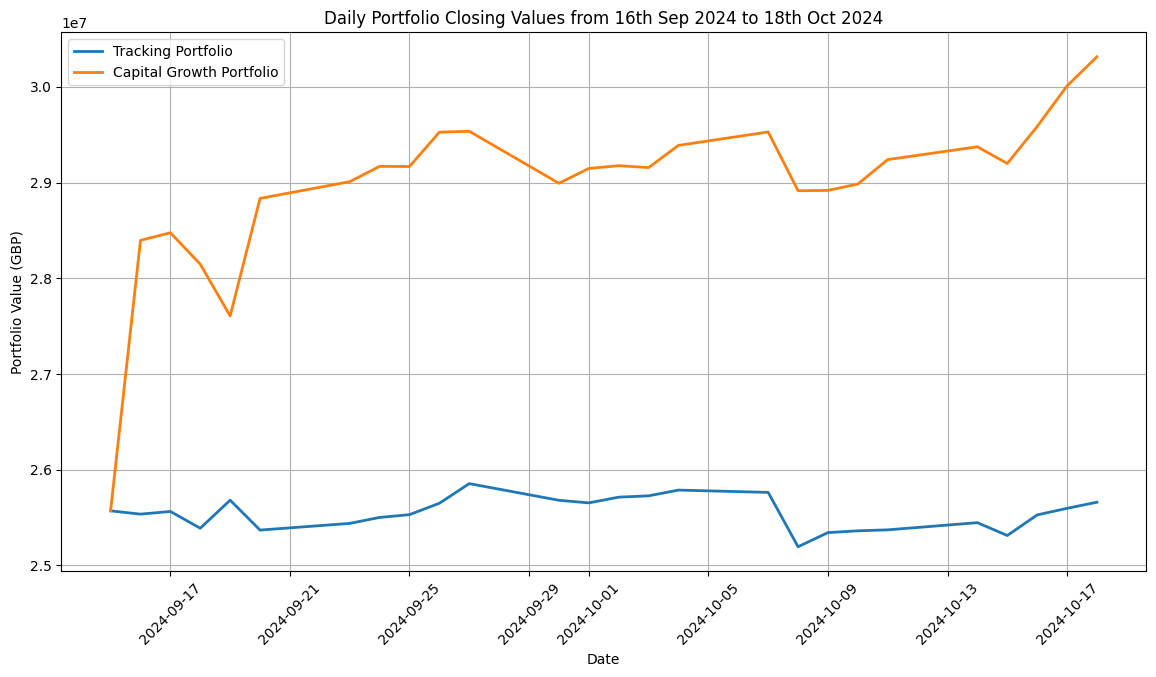

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df['Tracking Portfolio Value (GBP)'], label='Tracking Portfolio', linewidth=2)
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df['Capital Growth Portfolio Value (GBP)'], label='Capital Growth Portfolio', linewidth=2)
plt.title('Daily Portfolio Closing Values from 16th Sep 2024 to 18th Oct 2024')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Portfolio Value (GBP)')
plt.legend()
plt.grid(True)
plt.show()

                           Tracking Portfolio Value (GBP)  \
2024-09-15 00:00:00+00:00                    2.557000e+07   
2024-09-16 00:00:00+00:00                    2.553550e+07   
2024-09-17 00:00:00+00:00                    2.556346e+07   
2024-09-18 00:00:00+00:00                    2.538830e+07   
2024-09-19 00:00:00+00:00                    2.568123e+07   
2024-09-20 00:00:00+00:00                    2.536893e+07   
2024-09-23 00:00:00+00:00                    2.543880e+07   
2024-09-24 00:00:00+00:00                    2.550103e+07   
2024-09-25 00:00:00+00:00                    2.552997e+07   
2024-09-26 00:00:00+00:00                    2.564909e+07   
2024-09-27 00:00:00+00:00                    2.585429e+07   
2024-09-30 00:00:00+00:00                    2.568013e+07   
2024-10-01 00:00:00+00:00                    2.565307e+07   
2024-10-02 00:00:00+00:00                    2.571304e+07   
2024-10-03 00:00:00+00:00                    2.572665e+07   
2024-10-04 00:00:00+00:0

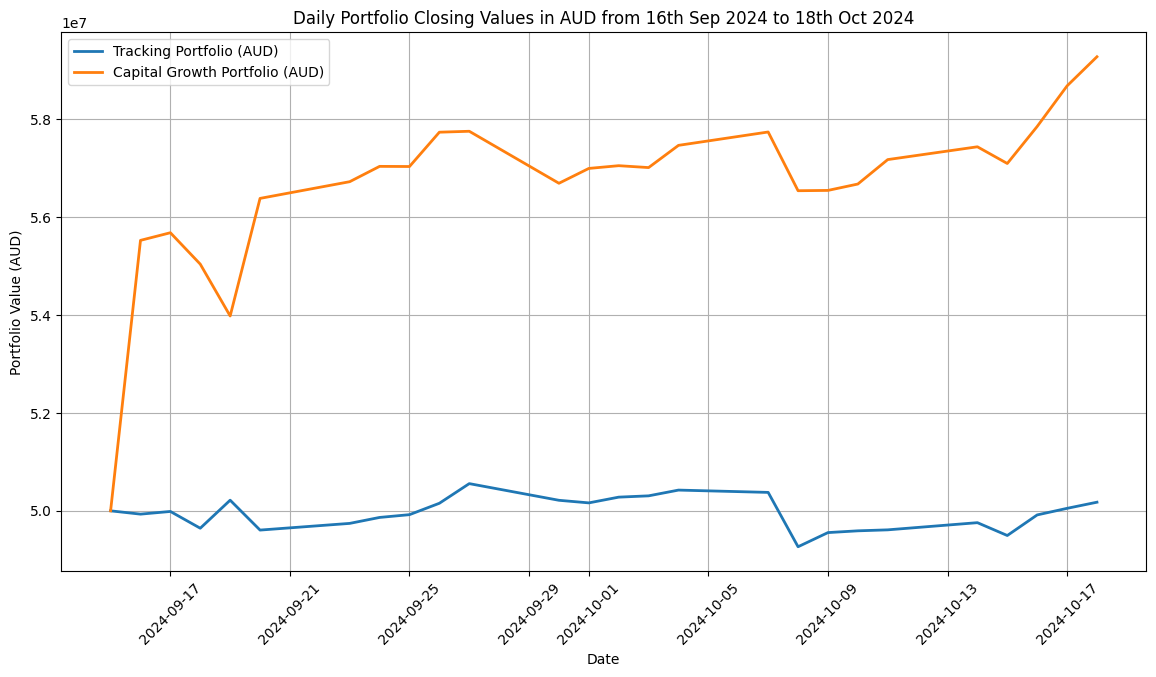

In [31]:
portfolios_daily_value_df["Tracking Portfolio Value (AUD)"] = portfolios_daily_value_df["Tracking Portfolio Value (GBP)"] / exchange_rate
portfolios_daily_value_df["Capital Growth Portfolio Value (AUD)"] = portfolios_daily_value_df["Capital Growth Portfolio Value (GBP)"] / exchange_rate

print(portfolios_daily_value_df)

plt.figure(figsize=(14, 7))
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df["Tracking Portfolio Value (AUD)"], label="Tracking Portfolio (AUD)", linewidth=2)
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df["Capital Growth Portfolio Value (AUD)"], label="Capital Growth Portfolio (AUD)", linewidth=2)
plt.title("Daily Portfolio Closing Values in AUD from 16th Sep 2024 to 18th Oct 2024")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Portfolio Value (AUD)")
plt.legend()
plt.grid(True)
plt.show()

### **Question 2B** 
The daily growth in the dollar value of your portfolios.

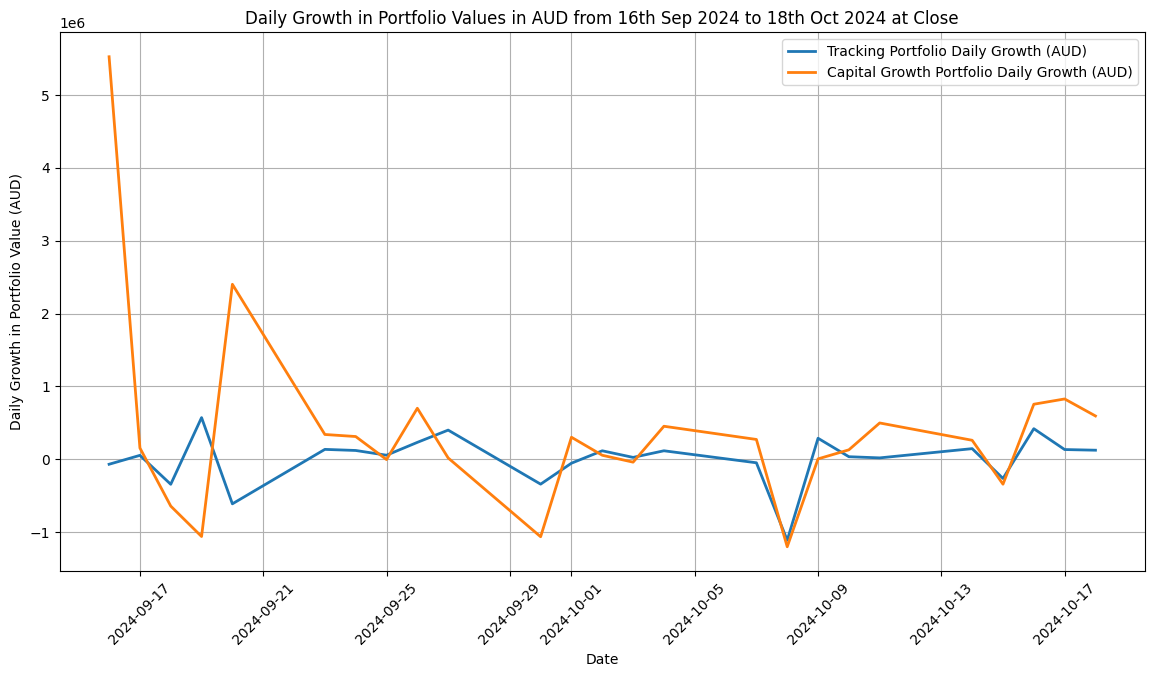

,Tracking Portfolio Value (GBP),Capital Growth Portfolio Value (GBP),Tracking Portfolio Value (AUD),Capital Growth Portfolio Value (AUD),Tracking Portfolio Daily Growth (AUD),Capital Growth Portfolio Daily Growth (AUD)
2024-09-15 00:00:00+00:00,2.557000e+07,2.557000e+07,5.000000e+07,5.000000e+07,NaN,NaN
2024-09-16 00:00:00+00:00,2.553550e+07,2.839579e+07,4.993253e+07,5.552559e+07,-6.747012e+04,5.525594e+06
2024-09-17 00:00:00+00:00,2.556346e+07,2.847552e+07,4.998721e+07,5.568150e+07,5.468116e+04,1.559073e+05
2024-09-18 00:00:00+00:00,2.538830e+07,2.814737e+07,4.964469e+07,5.503982e+07,-3.425182e+05,-6.416788e+05
2024-09-19 00:00:00+00:00,2.568123e+07,2.760571e+07,5.021750e+07,5.398066e+07,5.728040e+05,-1.059164e+06
2024-09-20 00:00:00+00:00,2.536893e+07,2.883428e+07,4.960682e+07,5.638303e+07,-6.106787e+05,2.402367e+06
2024-09-23 00:00:00+00:00,2.543880e+07,2.900875e+07,4.974345e+07,5.672420e+07,1.366285e+05,3.411721e+05
2024-09-24 00:00:00+00:00,2.550103e+07,2.916885e+07,4.986514e+07,5.703725e+07,1.216894e+05,3.130573e+05
2024-09-25 00:00:00+00:00,2.552997e+07,2.916734e+07,4.992173e+07,5.703429e+07,5.659680e+04,-2.963843e+03
2024-09-26 00:00:00+00:00,2.564909e+07,2.952588e+07,5.015465e+07,5.773540e+07,2.329172e+05,7.011069e+05


In [32]:
portfolios_daily_value_df["Tracking Portfolio Daily Growth (AUD)"] = portfolios_daily_value_df["Tracking Portfolio Value (AUD)"].diff()
portfolios_daily_value_df["Capital Growth Portfolio Daily Growth (AUD)"] = portfolios_daily_value_df["Capital Growth Portfolio Value (AUD)"].diff()

plt.figure(figsize=(14, 7))
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df["Tracking Portfolio Daily Growth (AUD)"], label="Tracking Portfolio Daily Growth (AUD)", linewidth=2)
plt.plot(portfolios_daily_value_df.index, portfolios_daily_value_df["Capital Growth Portfolio Daily Growth (AUD)"], label="Capital Growth Portfolio Daily Growth (AUD)", linewidth=2)
plt.title("Daily Growth in Portfolio Values in AUD from 16th Sep 2024 to 18th Oct 2024 at Close")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Daily Growth in Portfolio Value (AUD)")
plt.legend()
plt.grid(True)
plt.show()

display(HTML(portfolios_daily_value_df.to_html()))

### **Question 4**
The continuously compounded percentage growth rate of the portfolios.

(Assumed to be over the investment period).

In [33]:
tracking_period_growth_rate = np.log(portfolios_daily_value_df["Tracking Portfolio Value (AUD)"].iloc[-1] / portfolios_daily_value_df["Tracking Portfolio Value (AUD)"].iloc[0]) * 100
capital_growth_period_growth_rate = np.log(portfolios_daily_value_df["Capital Growth Portfolio Value (AUD)"].iloc[-1] / portfolios_daily_value_df["Capital Growth Portfolio Value (AUD)"].iloc[0]) * 100

portfolios_growth_rates_df = pd.DataFrame({
    "Metric": ["Tracking Portfolio Period Growth Rate", "Growth Portfolio Period Growth Rate"],
    "Rate (%)": [tracking_period_growth_rate, capital_growth_period_growth_rate]
})

display(HTML(portfolios_growth_rates_df.to_html()))


,Metric,Rate (%)
0,Tracking Portfolio Period Growth Rate,0.351933
1,Growth Portfolio Period Growth Rate,17.019260


### **Question 5** 
The daily continuously compounded returns and the corresponding per annum expected return and standard deviation of returns for each stock in your portfolios.

In [34]:
def calculate_annualized_return_std(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)["Adj Close"]
    
    daily_returns = np.log(data / data.shift(1)).dropna()
    
    expected_daily_return = daily_returns.mean()
    daily_std_dev = daily_returns.std()
    
    annualized_return = expected_daily_return * 252
    annualized_std_dev = daily_std_dev * np.sqrt(252)
    
    res = pd.DataFrame({
        "Annualized Expected Return (%)": annualized_return * 100,
        "Annualized Std Dev": annualized_std_dev
    }, index=tickers)

    plt.figure(figsize=(12, 6))
    for ticker in tickers:
        plt.plot(daily_returns.index, daily_returns[ticker], label=ticker)
    plt.title("Continuously Compounded Daily Returns")
    plt.xlabel("Date")
    plt.ylabel("Daily Returns")
    plt.legend()
    plt.show()
    
    return res

[*********************100%***********************]  20 of 20 completed


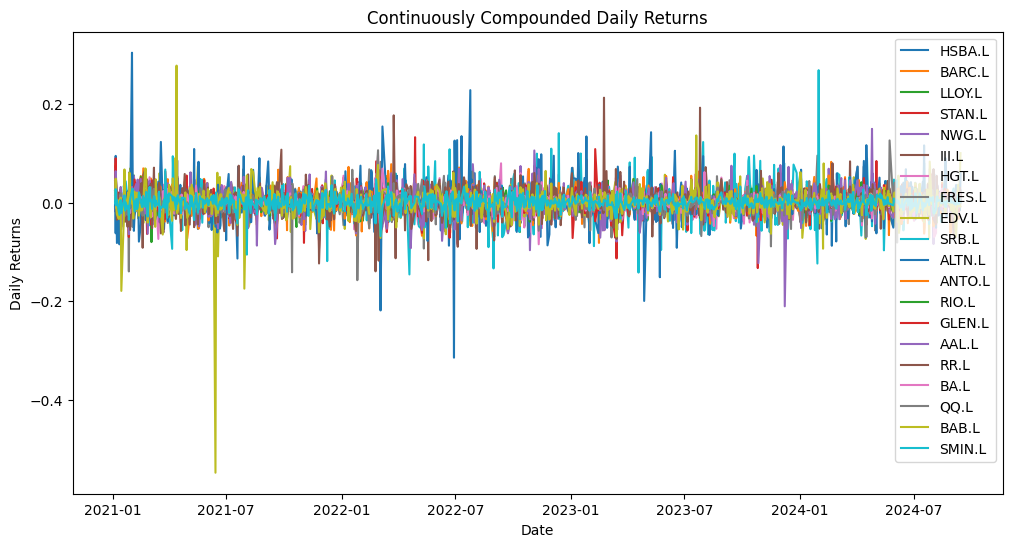

[*********************100%***********************]  30 of 30 completed


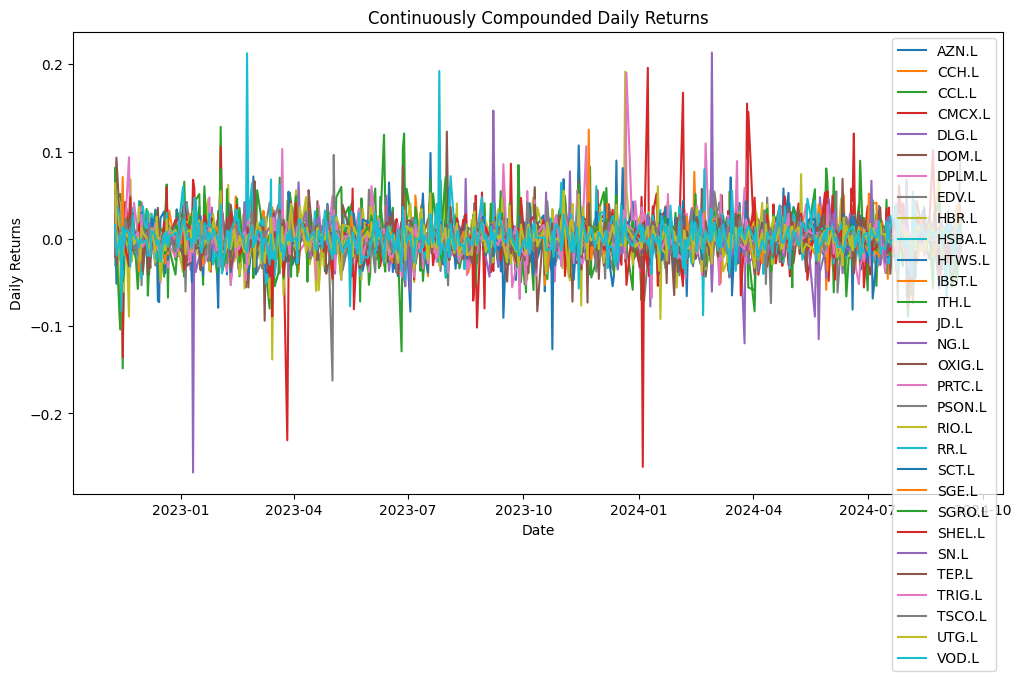

,Annualized Expected Return (%),Annualized Std Dev
HSBA.L,25.547226,0.248019
BARC.L,16.085505,0.312617
LLOY.L,20.472418,0.267967
STAN.L,18.741858,0.324878
NWG.L,26.621672,0.298942
III.L,27.147109,0.262902
HGT.L,14.797592,0.305343
FRES.L,-19.458486,0.381591
EDV.L,-11.025199,0.454241
SRB.L,-4.787203,0.512259


,Annualized Expected Return (%),Annualized Std Dev
AZN.L,7.369751,0.217601
CCH.L,20.417953,0.176334
CCL.L,33.042779,0.499978
CMCX.L,18.515008,0.443984
DLG.L,-3.099988,0.420682
DOM.L,14.522715,0.299649
DPLM.L,27.916164,0.252359
EDV.L,7.068137,0.325609
HBR.L,-14.826853,0.427026
HSBA.L,28.425744,0.214782


In [35]:
growth_stocks_summary_statistics_df = calculate_annualized_return_std(growth_stocks, "2021-01-01", "2024-09-15")
tracking_stocks_summary_statistics_df = calculate_annualized_return_std(tracking_stocks, "2021-01-01", "2024-09-15")

display(HTML(growth_stocks_summary_statistics_df.to_html()))
display(HTML(tracking_stocks_summary_statistics_df.to_html()))

### **Question 6** 
The correlation between the selected stocks in each portfolio.

In [36]:
def calculate_stock_return_correlation(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    daily_returns = np.log(data / data.shift(1))
    return daily_returns.corr()


In [37]:
growth_stocks_correlation = calculate_stock_return_correlation(growth_stocks, "2021-01-01", "2024-09-15").round(3)
tracking_stocks_correlation = calculate_stock_return_correlation(tracking_stocks, "2021-01-01", "2024-09-15").round(3)

display(HTML(growth_stocks_correlation.to_html()))
display(HTML(tracking_stocks_correlation.to_html()))

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  30 of 30 completed


Ticker,AAL.L,ALTN.L,ANTO.L,BA.L,BAB.L,BARC.L,EDV.L,FRES.L,GLEN.L,HGT.L,HSBA.L,III.L,LLOY.L,NWG.L,QQ.L,RIO.L,RR.L,SMIN.L,SRB.L,STAN.L
Ticker,,,,,,,,,,,,,,,,,,,,
AAL.L,1.000,0.086,0.681,0.095,0.220,0.402,0.270,0.391,0.715,0.233,0.311,0.270,0.327,0.373,0.105,0.746,0.212,0.276,0.097,0.327
ALTN.L,0.086,1.000,0.069,0.023,0.012,0.029,0.113,0.142,0.076,0.068,0.017,0.083,0.033,0.062,-0.030,0.053,0.029,0.056,0.140,0.031
ANTO.L,0.681,0.069,1.000,0.147,0.231,0.407,0.243,0.401,0.703,0.250,0.334,0.315,0.354,0.373,0.147,0.694,0.256,0.336,0.081,0.344
BA.L,0.095,0.023,0.147,1.000,0.266,0.073,0.076,0.070,0.188,0.025,0.144,0.112,0.045,0.027,0.425,0.138,0.200,0.212,0.069,0.099
BAB.L,0.220,0.012,0.231,0.266,1.000,0.294,0.099,0.085,0.239,0.137,0.200,0.197,0.257,0.249,0.300,0.215,0.282,0.252,0.093,0.187
BARC.L,0.402,0.029,0.407,0.073,0.294,1.000,0.115,0.092,0.452,0.337,0.622,0.471,0.767,0.735,0.167,0.358,0.460,0.430,0.073,0.634
EDV.L,0.270,0.113,0.243,0.076,0.099,0.115,1.000,0.396,0.225,0.117,0.037,0.102,0.099,0.099,0.059,0.222,0.073,0.094,0.138,0.087
FRES.L,0.391,0.142,0.401,0.070,0.085,0.092,0.396,1.000,0.330,0.154,-0.010,0.076,0.050,0.110,0.023,0.320,0.035,0.112,0.121,0.049
GLEN.L,0.715,0.076,0.703,0.188,0.239,0.452,0.225,0.330,1.000,0.238,0.378,0.280,0.388,0.394,0.143,0.715,0.255,0.323,0.072,0.373


Ticker,AZN.L,CCH.L,CCL.L,CMCX.L,DLG.L,DOM.L,DPLM.L,EDV.L,HBR.L,HSBA.L,HTWS.L,IBST.L,ITH.L,JD.L,NG.L,OXIG.L,PRTC.L,PSON.L,RIO.L,RR.L,SCT.L,SGE.L,SGRO.L,SHEL.L,SN.L,TEP.L,TRIG.L,TSCO.L,UTG.L,VOD.L
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AZN.L,1.000,0.203,0.084,0.094,0.111,0.083,0.159,0.069,0.027,0.168,0.028,0.126,0.064,0.083,0.266,0.086,0.155,0.137,0.066,0.072,0.129,0.180,0.178,0.086,0.256,0.150,0.081,0.153,0.172,0.088
CCH.L,0.203,1.000,0.231,0.108,0.221,0.182,0.277,0.005,0.011,0.256,0.206,0.288,0.100,0.278,0.185,0.164,0.145,0.150,0.119,0.275,0.230,0.233,0.210,0.072,0.253,0.145,0.063,0.246,0.258,0.252
CCL.L,0.084,0.231,1.000,0.152,0.120,0.223,0.285,0.079,0.200,0.303,0.240,0.301,0.137,0.332,0.057,0.263,0.209,0.135,0.234,0.425,0.304,0.209,0.235,0.209,0.243,0.105,0.216,0.096,0.281,0.154
CMCX.L,0.094,0.108,0.152,1.000,0.124,0.134,0.244,0.138,0.067,0.131,0.151,0.184,0.070,0.190,0.035,0.165,0.153,0.058,0.107,0.148,0.212,0.049,0.199,0.093,0.226,0.112,0.093,0.148,0.184,0.123
DLG.L,0.111,0.221,0.120,0.124,1.000,0.152,0.187,0.062,0.067,0.211,0.130,0.193,0.039,0.177,0.136,0.134,0.117,0.105,0.114,0.193,0.176,0.106,0.194,0.153,0.153,0.094,0.190,0.183,0.204,0.185
DOM.L,0.083,0.182,0.223,0.134,0.152,1.000,0.273,0.130,0.077,0.147,0.210,0.259,0.082,0.242,0.122,0.253,0.133,0.057,0.140,0.184,0.295,0.146,0.276,0.056,0.173,0.140,0.201,0.179,0.296,0.139
DPLM.L,0.159,0.277,0.285,0.244,0.187,0.273,1.000,0.109,0.049,0.163,0.273,0.384,0.106,0.393,0.161,0.391,0.209,0.155,0.163,0.160,0.483,0.430,0.430,0.034,0.282,0.198,0.238,0.206,0.370,0.133
EDV.L,0.069,0.005,0.079,0.138,0.062,0.130,0.109,1.000,0.097,0.037,0.074,0.042,0.094,0.098,0.091,0.064,0.109,0.014,0.222,0.073,0.124,0.056,0.154,0.086,0.033,0.032,0.104,0.073,0.141,0.061
HBR.L,0.027,0.011,0.200,0.067,0.067,0.077,0.049,0.097,1.000,0.235,0.078,0.197,0.434,0.092,-0.005,0.113,0.091,0.091,0.364,0.196,0.092,-0.005,0.050,0.556,0.085,0.111,0.087,0.092,0.113,0.195


### **Question 7** 
The mean and standard deviation of each portfolio’ return compared with the mean and standard deviation of the FTSE 100 over the investment horizon.

In [38]:
ftse_close_data = yf.download("^FTSE", start="2024-09-16", end="2024-10-19")
ftse_open_data = yf.download("^FTSE", start="2024-09-16", end="2024-09-17", progress=False)[["Open"]]

# print(ftse_open_data) # Equals 8273.099609

initial_value = 8273.099609

new_row = pd.DataFrame({col: [initial_value] for col in ftse_close_data.columns}, 
                       index=[pd.Timestamp("2024-09-15", tz="UTC")])

ftse_close_data = pd.concat([new_row, ftse_close_data])

ftse_returns = ftse_close_data['Adj Close'].pct_change().dropna()
print(ftse_returns)

mean_ftse_close = ftse_returns.mean().item()
std_ftse_close = ftse_returns.std().item()

tracking_stock_returns = portfolios_daily_value_df["Tracking Portfolio Value (GBP)"].pct_change().dropna()
growth_stock_returns = portfolios_daily_value_df["Capital Growth Portfolio Value (GBP)"].pct_change().dropna()

tracking_mean_returns = tracking_stock_returns.mean()
tracking_std_returns = tracking_stock_returns.std()

growth_mean_returns = growth_stock_returns.mean()
growth_std_returns = growth_stock_returns.std()


[*********************100%***********************]  1 of 1 completed


                              ^FTSE
2024-09-16 00:00:00+00:00  0.000641
2024-09-17 00:00:00+00:00  0.003805
2024-09-18 00:00:00+00:00 -0.006763
2024-09-19 00:00:00+00:00  0.009087
2024-09-20 00:00:00+00:00 -0.011851
2024-09-23 00:00:00+00:00  0.003609
2024-09-24 00:00:00+00:00  0.002797
2024-09-25 00:00:00+00:00 -0.001702
2024-09-26 00:00:00+00:00  0.001959
2024-09-27 00:00:00+00:00  0.004333
2024-09-30 00:00:00+00:00 -0.010071
2024-10-01 00:00:00+00:00  0.004820
2024-10-02 00:00:00+00:00  0.001716
2024-10-03 00:00:00+00:00 -0.001013
2024-10-04 00:00:00+00:00 -0.000229
2024-10-07 00:00:00+00:00  0.002778
2024-10-08 00:00:00+00:00 -0.013608
2024-10-09 00:00:00+00:00  0.006483
2024-10-10 00:00:00+00:00 -0.000728
2024-10-11 00:00:00+00:00  0.001942
2024-10-14 00:00:00+00:00  0.004725
2024-10-15 00:00:00+00:00 -0.005234
2024-10-16 00:00:00+00:00  0.009674
2024-10-17 00:00:00+00:00  0.006723
2024-10-18 00:00:00+00:00 -0.003196


In [39]:
portfolios_summary_stats_df = pd.DataFrame({
    'Mean Returns (%)': [mean_ftse_close * 100, growth_mean_returns * 100, tracking_mean_returns * 100],
    'Standard Deviation': [std_ftse_close, growth_std_returns, tracking_std_returns]
}, index=['FTSE', 'Growth Portfolio', 'Tracking Portfolio'])

display(HTML(portfolios_summary_stats_df.to_html()))


,Mean Returns (%),Standard Deviation
FTSE,0.042781,0.006097
Growth Portfolio,0.711877,0.025137
Tracking Portfolio,0.016358,0.006870


### **Question 9** 
The minimum variance set (MVS) for the index tracking portfolio. Which stocks are mean-variance efficient?

In [40]:
tracking_stock_close = yf.download(tracking_stocks, "2021-01-01", "2024-09-15")['Adj Close']

def portfolio_variance(w, Sigma):
    return w.T @ Sigma @ w

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(len(tracking_stocks)))

[*********************100%***********************]  30 of 30 completed


In [41]:
tracking_stocks_daily_returns = tracking_stock_close.pct_change().dropna()

z = tracking_stocks_daily_returns.mean()
Sigma = tracking_stocks_daily_returns.cov()

guess = np.array([1.0 / 30] * 30)

mvp = minimize(
    fun=portfolio_variance,
    x0=guess,
    args=(Sigma),
    # method='trust-constr',
    method='SLSQP',
    bounds=bounds,
    constraints=consts
)

w_mvp = mvp.x

mu_mvp = np.dot(z, w_mvp)
var_mvp = portfolio_variance(w_mvp, Sigma)

mvp_weights_df = pd.DataFrame({
    "Ticker": tracking_stock_close.columns,
    "MVP Weight": w_mvp
})

mvp_weights_df['MVP Weight'] = mvp_weights_df['MVP Weight'].map('{:.6f}'.format)

display(HTML(mvp_weights_df.to_html()))


C:\Users\dhwan\AppData\Local\Temp\ipykernel_26180\3995907162.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tracking_stocks_daily_returns = tracking_stock_close.pct_change().dropna()


,Ticker,MVP Weight
0,AZN.L,0.036720
1,CCH.L,0.024925
2,CCL.L,0.009251
3,CMCX.L,0.022979
4,DLG.L,0.039752
5,DOM.L,0.029662
6,DPLM.L,0.015034
7,EDV.L,0.030730
8,HBR.L,0.047728
9,HSBA.L,0.020419


### **Question 8** 
The minimum variance set (MVS) for the index tracking portfolio. Which stocks are mean-variance efficient?

In [42]:
tracking_stock_close = yf.download(tracking_stocks, "2021-01-01", "2024-09-15")['Adj Close']

daily_returns = tracking_stock_close.pct_change().dropna()
mu_d = daily_returns.mean()
Sigma = daily_returns.cov()

[*********************100%***********************]  30 of 30 completed
C:\Users\dhwan\AppData\Local\Temp\ipykernel_26180\795087673.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = tracking_stock_close.pct_change().dropna()


In [43]:
def portfolio_performance(weights, mu_d, Sigma):
    returns = np.dot(weights, mu_d)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return std_dev, returns

In [44]:
def get_constraints(target_return):
    return ({
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }, {
        'type': 'eq',
        'fun': lambda weights: np.dot(weights, mu_d) - target_return
    })

bounds = tuple((0, 1) for _ in range(len(tracking_stocks)))

target_returns = np.linspace(mu_d.min(), mu_d.max(), 100)
ef_stds = []
ef_mus = []

In [45]:
for target_return in target_returns:
    constraints = get_constraints(target_return)

    result = minimize(
        lambda weights: portfolio_performance(weights, mu_d, Sigma)[0],  
        x0=np.array([1/len(tracking_stocks)] * len(tracking_stocks)),  
        constraints=constraints,
        bounds=bounds
    )

    if result.success:
        risk, ret = portfolio_performance(result.x, mu_d, Sigma)
        ef_stds.append(risk)
        ef_mus.append(ret)

port_returns = []
port_risks = []

for _ in range(10000):
    weights = np.random.random(len(tracking_stocks))
    weights /= np.sum(weights)
    risk, ret = portfolio_performance(weights, mu_d, Sigma)
    port_returns.append(ret)
    port_risks.append(risk)



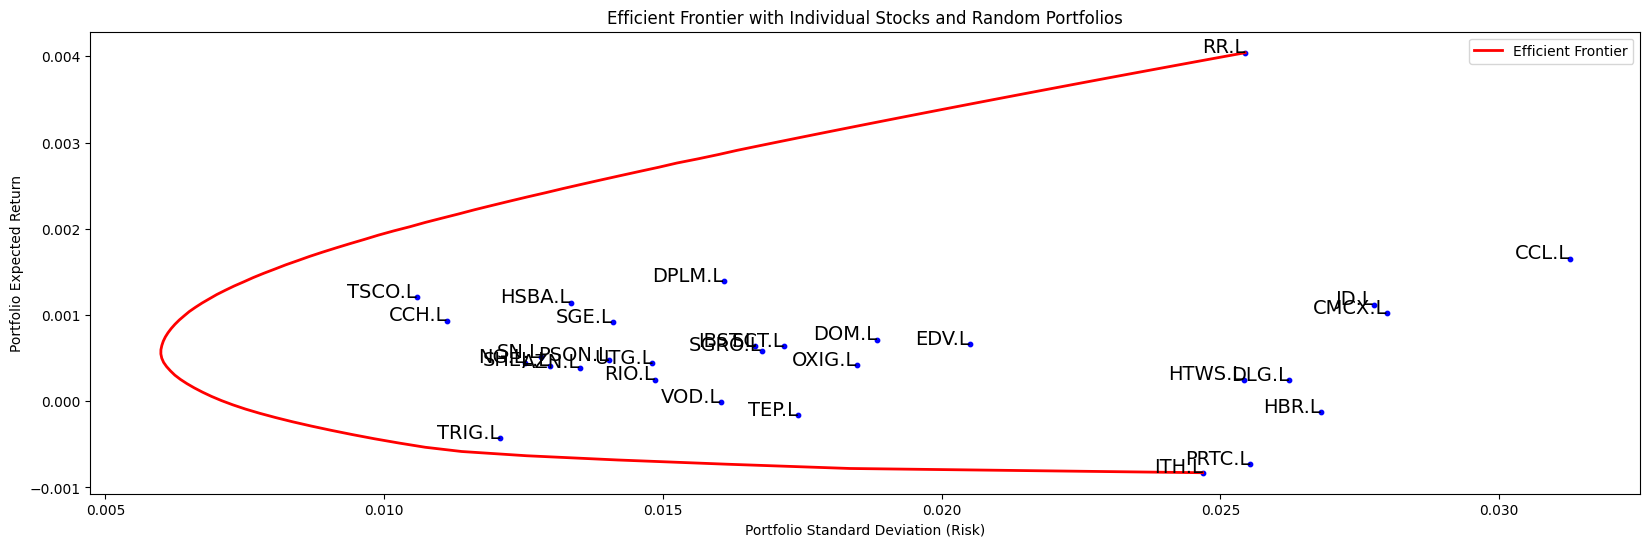

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(ef_stds, ef_mus, color='red', linewidth=2, label='Efficient Frontier')

for i, stock in enumerate(tracking_stocks):
    plt.scatter(daily_returns[stock].std(), mu_d[stock], color='blue', marker='o', s=10)
    plt.text(daily_returns[stock].std(), mu_d[stock], stock, fontsize=14, ha='right')
    

plt.xlabel('Portfolio Standard Deviation (Risk)')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier with Individual Stocks and Random Portfolios')
plt.legend()
plt.show()

### **Question 10** 
The performance of each of the portfolios as measured against their stated aims and by applying appropriate performance measures.

Tracking Portfolio: Expected Return Difference and Deviation of Return Differenc

In [47]:
mean_ftse_returns = portfolios_summary_stats_df.loc['FTSE', 'Mean Returns (%)']
mean_tracking_returns = portfolios_summary_stats_df.loc['Tracking Portfolio', 'Mean Returns (%)']

mean_return_difference_tracking = mean_ftse_returns - mean_tracking_returns
print(f"The difference in mean return between the FTSE and the tracking portfolio is {mean_return_difference_tracking:.6f}%")


The difference in mean return between the FTSE and the tracking portfolio is 0.026422%


In [48]:
ftse_returns.columns = ['FTSE_Returns']
combined_df = pd.concat([tracking_stock_returns, ftse_returns], axis=1)
combined_df.columns = ['Tracking_Stock_Returns', 'FTSE_Returns']

std_tracking = combined_df['Tracking_Stock_Returns'].std()
std_ftse = combined_df['FTSE_Returns'].std()

cov_tracking_ftse = np.cov(combined_df['Tracking_Stock_Returns'], combined_df['FTSE_Returns'])[0, 1]

std_difference = np.sqrt(std_tracking**2 + std_ftse**2 - 2 * cov_tracking_ftse)

print(std_difference)

0.0031843718014554954


Growth Portfolio: Expected Return Difference

In [49]:
mean_tracking_returns = portfolios_summary_stats_df.loc['Growth Portfolio', 'Mean Returns (%)']
mean_return_difference_growth = mean_tracking_returns - mean_ftse_returns 


print(f"The difference in mean return between the FTSE and the growth portfolio is {mean_return_difference_growth:.6f}%")

The difference in mean return between the FTSE and the growth portfolio is 0.669096%
